In [1]:
import numpy as np
from scipy.constants import c, m_e, elementary_charge
import h5py as hp
import matplotlib.pyplot as plt
from mbtrack2 import Synchrotron, Electron
from mbtrack2.utilities import Optics
from mbtrack2.impedance.wakefield import WakeField
from mbtrack2.tracking import LongitudinalMap, SynchrotronRadiation, TransverseMap
from mbtrack2.tracking import Beam, Bunch, WakePotential
from mbtrack2.tracking import RFCavity, SynchrotronRadiation
from mbtrack2.tracking.monitors import BunchMonitor, WakePotentialMonitor
from mbtrack2.tracking.feedback import FIRDamper, ExponentialDamper
import at
from tqdm import tqdm
from time import time
import scipy.integrate as quad
from scipy.special import lpmv, hyp2f1

def v2366(IDs="close", lat="V004", load_lattice=True):
    """
    TDR lattice using V2366_V004_Physical_Aperture.m

    Returns
    -------
    ring : Synchrotron object

    """    
    
    h = 416
    particle = Electron()
    tau = np.array([7.68e-3, 14.14e-3, 12.18e-3])
    sigma_0 = 9e-12
    sigma_delta = 9.07649e-4
    emit = np.array([84.4e-12, 84.4e-13])
    # [84.4e-12, 84.4e-13]
    
    if load_lattice:
        if IDs=="close":
            lattice_file = "V3588_RING_for_Salah.mat"
        else:
            lattice_file = "V3588_RING_for_Salah.mat"
    
        # mean values
        alpha = np.array([0, 0])
        optics = Optics(lattice_file=lattice_file, local_alpha=alpha, n_points=1e4)
        
        ring = Synchrotron(h, optics, particle, tau=tau, emit=emit, 
                           sigma_0=sigma_0, sigma_delta=sigma_delta)
    else:
        L = 353.97
        E0 = 2.75e9
        particle = Electron()
        ac = 1.0695e-4
        U0 = 452.6e3
        tune = np.array([54.2, 18.3])
        chro = np.array([1.6, 1.6])
        
        beta = np.array([3.288, 4.003])
        alpha = np.array([0, 0])
        dispersion = np.array([0, 0, 0, 0])
        
        optics = Optics(local_beta=beta, local_alpha=alpha, 
                      local_dispersion=dispersion)
        ring = Synchrotron(h, optics, particle, L=L, E0=E0, ac=ac, U0=U0, tau=tau,
                       emit=emit, tune=tune, sigma_delta=sigma_delta, 
                       sigma_0=sigma_0, chro=chro)
    
    return ring
    
def model_ring():
    h = 416 # Harmonic number of the accelerator.
    L = 353.97 # Ring circumference in [m].
    E0 = 2.75e9 # Nominal (total) energy of the ring in [eV].
    particle = Electron() # Particle considered.
    ac = 1.0695e-4
    U0 = 452.6e3# Energy loss per turn in [eV].
    tau = np.array([7.68e-3, 14.14e-3, 12.18e-3]) #horizontal, vertical and longitudinal damping times in [s].
    tune = np.array([54.2, 18.3])
    emit = np.array([84.4e-12, 84.4e-13])
    sigma_0 = 9e-12
    sigma_delta = 9.07649e-4
    chro = np.array([1.6, 1.6])
    beta = np.array([3.288, 4.003])
    alpha = np.array([0, 0])
    dispersion = np.array([0, 0, 0, 0])
    optics = Optics(local_beta=beta, local_alpha=alpha, 
                      local_dispersion=dispersion)
    ring3 = Synchrotron(h=h, optics=optics, particle=particle, L=L, E0=E0, ac=ac,
                       U0=U0, tau=tau, emit=emit, tune=tune,
                       sigma_delta=sigma_delta, sigma_0=sigma_0, chro=chro)
    return ring3
#Particles number
def run_mbtrack2(
    n_turns=900,
    n_macroparticles=9000,
    bunch_current=1.2e-2,
):
    # ring
    ring3 = model_ring()
    ring = v2366(IDs="open")
    ring2 = ring
    # ring2.emit[1] = .3*ring2.emit[0]
    # ring2.tau[0] = ring2.tau[0]/1
    # ring2.tau[1] = ring2.tau[1]/1
    # ring2.tau[2] = ring2.tau[2]/1

    particle = Electron()
    # bunch
    mybunch = Bunch(
        ring2, mp_number=n_macroparticles, current=bunch_current, track_alive=False
    )
    np.random.seed(42)
    mybunch.init_gaussian()
    # offset 
    # mybunch['x'] = +1e-3
    # mybunch['y'] = +1e-3
    #Tracking elements
    long_map = LongitudinalMap(ring)
    sr = SynchrotronRadiation(ring, switch=[1, 1, 1])
    trans_map = TransverseMap(ring)
    V_rf  = 1.8e6 #1.8e6
    rf = RFCavity(ring2, m=1, Vc=V_rf, theta=np.arccos(ring.U0 / V_rf))
    # thetas = ((ring.U0/(V_rf * (2 * np.pi * ring.f0)**2)) - np.sqrt(2) / 2) * 1 / 0.5 * 4
    rf2 = RFCavity(ring2, m=2, Vc= 0.5*V_rf, theta=np.arccos(np.sqrt(2) / 2))

    tracking_elements = [trans_map, long_map, rf, sr]

    ##ibs track--------------------------------------------------------------------------------------------------------
    def track_ibs():
    #----------------------------init
        n=3000
        dt = 1 / ring.f0
        p0 = ring.E0 / c * elementary_charge
        p1 = ring.gamma * c * m_e
        N = (bunch_current / elementary_charge) * dt
        Spi = np.sqrt(np.pi)
        r_0 = 2.8179403227 * 1e-15
        s = np.linspace(0, ring.L, n)
        # betax = ring.optics.local_beta[0]
        # betay = ring.optics.local_beta[1]
        betax, betay = ring.optics.beta(s)
        gammax, gammay = ring.optics.gamma(s)
        alphax, alphay = ring.optics.alpha(s)
        # gammax = ring.gamma(s)
        # gammay = ring.gamma(s)
        sigma_s = np.std(mybunch['tau']) 
        sigma_p = np.std(mybunch['delta'])
        sigma_px = np.std(mybunch['xp'])
        sigma_py = np.std(mybunch['yp'])
        D_x, Dp_x, D_y, Dp_y = ring.optics.dispersion(s)
        # ----------------
        s = np.linspace(0, 350, n)
        # emit_x = (ring.optics.gamma(s)[0] * np.std(mybunch['x'])**2) + (2 * ring.optics.alpha(s)[0] * np.std(mybunch['x']) * np.std(mybunch['xp'])) + (ring.optics.beta(s)[0] * np.std(mybunch['xp'])**2) 
        # emit_y = (ring.optics.gamma(s)[1] * np.std(mybunch['y'])**2) + (2 * ring.optics.alpha(s)[1] * np.std(mybunch['y']) * np.std(mybunch['yp'])) + (ring.optics.beta(s)[1] * np.std(mybunch['yp'])**2)

        emit_x = mybunch.emit[0]
        emit_y = mybunch.emit[1]
        emit_x_all = np.std(emit_x)#np.std(mybunch['x'])**2 / betax #twiss
        emit_y_all = np.std(emit_y)#np.std(mybunch['y'])**2 / betay
        H_x = (1 / ring.optics.beta(s)[0]) * (ring.optics.dispX(s)**2 + 
                                       ((ring.optics.beta(s)[0] * ring.optics.disppX(s)) + (ring.optics.alpha(s)[0] * ring.optics.dispX(s)))**2)
        H_y = (1 / ring.optics.beta(s)[1]) * (ring.optics.dispY(s)**2 + 
                                       ((ring.optics.beta(s)[1] * ring.optics.disppY(s)) + (ring.optics.alpha(s)[1] * ring.optics.dispY(s)))**2)
        H = (1 / sigma_p**2) + (H_x / emit_x) + (H_y / emit_y)
        sigma_H = np.sqrt(1 / H)
        # A = (r_0**2 * c * N) / (64 * np.pi**2 * ring.beta**3 * ring.gamma**4 * emit_x_all * emit_y_all * sigma_s * sigma_p)
        a = (sigma_H / ring.gamma) * np.sqrt(ring.optics.beta(s)[0] / emit_x)
        b = (sigma_H / ring.gamma) * np.sqrt(ring.optics.beta(s)[1] / emit_y)
        C_log = np.log((ring.gamma**2 * emit_x * np.sqrt(ring.optics.beta(s)[1] * emit_y)) / (r_0 * ring.optics.beta(s)[0]))
        C_a = a / b
        
        A = (r_0**2 * N) / (64 * np.pi**2 * ring.beta**3 * ring.gamma**4 * emit_x * emit_y * sigma_s * sigma_p)
        
        h = (1 / sigma_p**2) + (ring.optics.dispX(s)**2 / (ring.optics.beta(s)[0] * emit_x)) + (ring.optics.dispY(s)**2 / (ring.optics.beta(s)[1] * emit_y))      
        sigma_h = np.sqrt(1 / h) # to uncomment
        # d = np.sqrt(np.std(mybunch['x'])**2 + np.std(mybunch['y'])**2)
        # maximum impact parameter (beam size) we use here the RMS of the beam size(assumes beams gaussian(circular)!!!)
        d = np.std(mybunch['y']) * 4
        # a_bar = (sigma_h / ring.gamma) * np.sqrt(betax / emit_x)
        # b_bar = (sigma_h / ring.gamma) * np.sqrt(betay / emit_y)
        q_bar = sigma_h * ring.beta * np.sqrt(2 * d / r_0)
        q = sigma_H * ring.beta * np.sqrt(2 * d / r_0)
        q_bar = q
        # print(a)
        # print(50*"-")
        # print(b)
        # print(50*'-')
        # print(q_bar)

        # ---------------------------------------
        def Puv(u, v, x):

            if x < 1:
                val = ((1 + x) / (1 - x))**(u/2) * hyp2f1(v+1, -v, 1-u, (.5 - (.5 * x)))
            else:
                val = ((1 + x) / (x - 1))**(u/2) * hyp2f1(v+1, -v, 1-u, (.5 - (.5 * x)))
            return val
        
        def g_func(u):
            x_arg = (1+ u**2) / (2 * u)
            if u >= 1:
                g_val = np.sqrt(np.pi / u) * ((Puv(0, -.5, x_arg)) + ((3/2) * (Puv(-1, -.5, x_arg))))
            else:
                g_val = np.sqrt(np.pi / u) * ((Puv(0, -.5, x_arg)) - ((3/2) * (Puv(-1, -.5, x_arg))))
            return g_val
            
        def g(u):
            if u <= 10:
                vg = (2.691 * (1 - (0.2288964 / u))) / ((1 + 0.16 * u) * (1 + (1.35 * np.exp(-u/0.2))))
            else: 
                vg = 0
            return vg
        

        
        def scattering_1bq(i, a, b, q_bar):
            f_1bq = ((-4 * np.pi**(3/4) * np.log(q_bar[i] / a[i])) / (1 / a[i])) * g_func(b[i] / a[i])
            return f_1bq
        
        def scattering_1aq(i, a, b, q_bar):
            f_1aq = ((-4 * np.pi**(3/4) * np.log(q_bar[i] / b[i])) / (1 / b[i])) * g_func(a[i] / b[i])
            return f_1aq
        
        def scattering_abq(i, a, b, q_bar):
            f_abq = -(scattering_1aq(i, a, b, q_bar) * (1/b[i]**2)) - (scattering_1bq(i, a, b, q_bar) * (1/a[i]**2))
            return f_abq
        
        
        vabq, v1aq, v1bq = [], [], []
        for i in range(n):
            el_abq = scattering_abq(i, a, b, q_bar)
            el_1aq = scattering_1aq(i, a, b, q_bar)
            el_1bq = scattering_1bq(i, a, b, q_bar)
            vabq.append(el_abq)
            v1aq.append(el_1aq)
            v1bq.append(el_1bq)
        
        

        # Piwinski
        # T_p = A * (vabq * (sigma_H**2/sigma_p**2)) #(T_i = 1/T_i in the model)/
        # T_x = A * (v1bq + (vabq * ((ring.optics.dispX(s)**2 * sigma_H**2) / (ring.optics.beta(s)[0] * emit_x))))
        # T_y = A * (v1aq + (vabq * ((ring.optics.dispY(s)**2 * sigma_H**2) / (ring.optics.beta(s)[1] * emit_y))))
        #Time:  3.01418840e-02  2.70946735e-02 -6.30232221e+01
        #Timed with V33: 0.01398050459600072 0.014738502941240048 0.16381405761959483 is in accordance with PIWINSKI 1 and 2 same lattice

        g_ab, g_ba = [], []
        for i in range(n):
            val_ab = g_func(a[i] / b[i])
            val_ba = g_func(b[i] / a[i]) 
            g_ab.append(val_ab)
            g_ba.append(val_ba)
        x=1

        
        #CIMP F.A
        # T_p = 2 * np.pi**(3/2) * A * C_log * ((sigma_H**2 / sigma_p**2) * ((g_ba/a)+(g_ab/b)))
        # T_x = 2 * np.pi**(3/2) * A * C_log * (((-a * g_ba) + ((H_x * sigma_H**2) / emit_x) * ((g_ba/a)+(g_ab/b))))
        # T_y = 2 * np.pi**(3/2) * A * C_log * (((-b * g_ab) + ((H_y * sigma_H**2) / emit_y) * ((g_ba/a)+(g_ab/b))))
        # time : 0.006862266151511072 0.005925548066732271 0.040070682063691083
        
        
        
        # Kubo Mtingwa
        T_p = 2 * np.pi**(3/2) * A * ((sigma_H**2 / sigma_p**2) * (((np.log(q**2 / a**2)* g_ba)/a)+((np.log(q**2/b**2)*g_ab)/b)))
        T_x = 2 * np.pi**(3/2) * A * (((-a * np.log(q**2/a**2) * g_ba) + (((H_x * sigma_H**2) / emit_x) * ((np.log(q**2 / a**2)* g_ba)/a)+(np.log(q**2/b**2)*g_ab)/b)))
        T_y = 2 * np.pi**(3/2) * A * (((-b * np.log(q**2/b**2) * g_ab) + (((H_y * sigma_H**2) / emit_y) * ((np.log(q**2 / a**2)* g_ba)/a)+(np.log(q**2/b**2)*g_ab)/b)))
        # time : 0.01204756 0.00932676 0.03419215
        # timed V33: 0.005924619205854546 0.004886493110205175 0.02561243904588912
        
        T_p = np.average(T_p)
        T_x = np.average(T_x)
        T_y = np.average(T_y)
        
        # print(1/T_p, 1/T_x, 1/T_y)
                 # ------------------------------------

        #calculating momentum kick
        # slicing = np.std(mybunch['tau']) / r_0
        # dz = np.hist(mybunch['tau'], bins=slicing)[0]
        # Rho = dz / r_0 #tbd

        
        Rho = 1.0 / (sigma_s * Spi * np.sqrt(2))
        
        Delta_pz = np.sign(T_p)*sigma_p * np.sqrt(2 * np.abs(T_p) * dt * sigma_s * Spi * Rho) * np.random.normal(size=n_macroparticles)
        Delta_px = np.sign(T_x)*sigma_px * np.sqrt(2 * np.abs(T_x) * dt * sigma_s * Spi * Rho) * np.random.normal(size=n_macroparticles)
        Delta_py = np.sign(T_y)*sigma_py * np.sqrt(2 * np.abs(T_y) * dt * sigma_s * Spi * Rho) * np.random.normal(size=n_macroparticles)
        # Delta_pz = sigma_p * np.sqrt(2 * (T_p) * dt * sigma_s * Spi * Rho) * np.random.random(size=n_macroparticles)
        # Delta_px = sigma_px * np.sqrt(2 * (T_x) * dt * sigma_s * Spi * Rho) * np.random.random(size=n_macroparticles)
        # Delta_py = sigma_py * np.sqrt(2 * (T_y) * dt * sigma_s * Spi * Rho) * np.random.random(size=n_macroparticles)
        # ------------------------------------------
        # applying kick------------
        mybunch['xp'] += Delta_px 
        mybunch['yp'] += Delta_py 
        mybunch['delta'] += Delta_pz 
        # print('deltas', Delta_px/p0)
        return 1/T_p, 1/T_x, 1/T_y
    x=1
                # mybunch['xp'], mybunch['yp'], mybunch['delta']
    #-------------------------------------------------------------------
    T_list = []
    emit_list = []
    coords = []
    # monitor = BunchMonitor(1, 1, buffer_size=n_turns, total_size=n_turns, file_name="_CIMP_test_50k_1.2_nc_vertical bunch lnght")
    for i in tqdm(range(n_turns)):
        # print(f'turn {i}')
        for el in tracking_elements:
            el.track(mybunch)
        t = track_ibs()
        T_list.append(t)
        emit_list.append(mybunch.emit)
        # coords.append([mybunch['x'], mybunch['xp'], mybunch['y'], mybunch['yp'], mybunch['tau'], mybunch['delta']])
        # monitor.track(mybunch)
    return T_list, emit_list

mbtrack2 version 0.8.0
--------------------------------------------------
If used in a publication, please cite mbtrack2 paper and the zenodo archive for the corresponding code version (and other papers for more specific features).
[1] A. Gamelin, W. Foosang, N. Yamamoto, V. Gubaidulin and R. Nagaoka, “mbtrack2”. Zenodo, Dec. 16, 2024. doi: 10.5281/zenodo.14418989.
[2] A. Gamelin, W. Foosang, and R. Nagaoka, “mbtrack2, a Collective Effect Library in Python”, presented at the 12th Int. Particle Accelerator Conf. (IPAC'21), Campinas, Brazil, May 2021, paper MOPAB070.




In [17]:
# run_mbtrack2(n_turns=5000,
#     n_macroparticles=50000,
#     bunch_current=1.2e-3)

In [29]:
T_list, emit_list = run_mbtrack2(n_turns=500,
    n_macroparticles=10000,
    bunch_current=20e-3)
T_list = np.array(T_list)


print(T_list*1e3)

100%|█████████████████████████████████████████| 500/500 [01:18<00:00,  6.35it/s]

[[  13.15920726  -98.70855236 -103.66338719]
 [  13.1531651   -98.66575422 -103.6110141 ]
 [  13.15143233  -98.6330442  -103.57966958]
 ...
 [  13.70291914 -103.48552673 -108.64695451]
 [  13.71225726 -103.57230783 -108.74339537]
 [  13.71470991 -103.6158118  -108.77853097]]


In [ ]:
coords = np.array(coords)
plt.scatter(coords[1, 0, :], coords[1, 1, :])
plt.scatter(coords[99, 0, :], coords[99, 1, :])


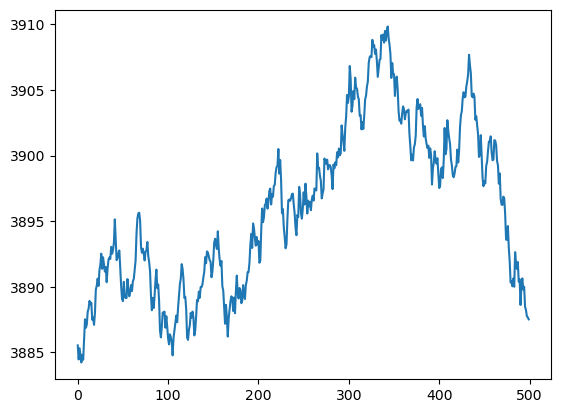

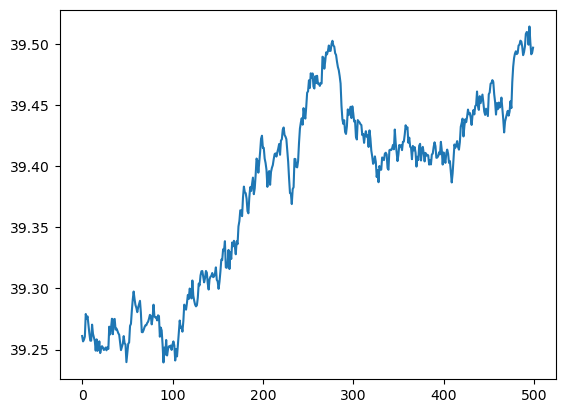

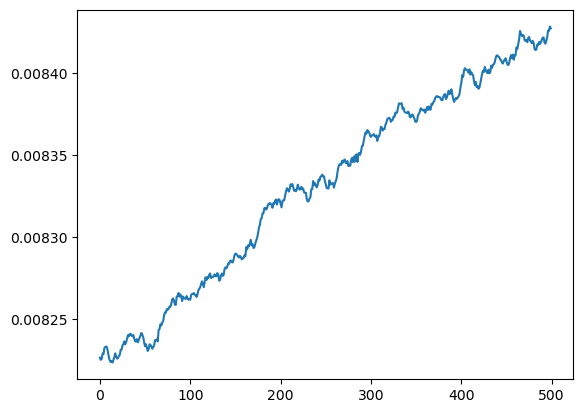

In [31]:
emit_list= np.array(emit_list)
plt.show()
plt.plot(emit_list[:, 0]*1e12, marker= '')
plt.show()
plt.plot(emit_list[:, 1]*1e12, marker= '')
plt.show()
plt.plot(emit_list[:, 2]*1e12, marker= '')

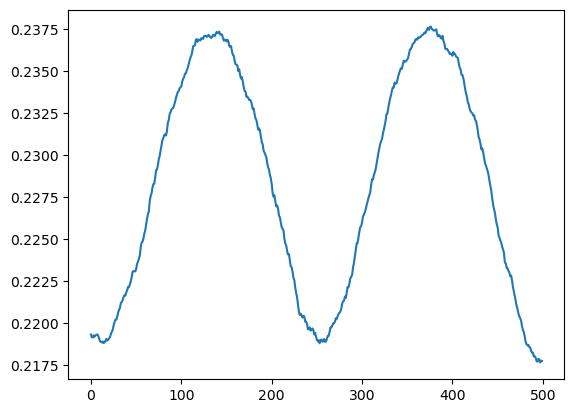

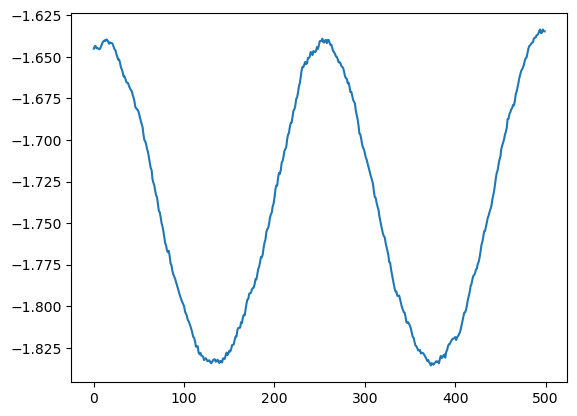

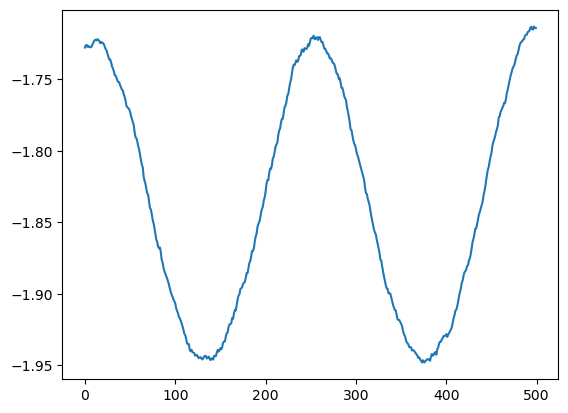

In [24]:
plt.show()
plt.plot(T_list[:, 0])
plt.show()
plt.plot(T_list[:, 1])
plt.show()
plt.plot(T_list[:, 2])

<KeysViewHDF5 ['BunchData_1']>
['cs_invariant', 'current', 'emit', 'mean', 'std', 'time']
[array([1.75127219e-05, 1.73335269e-05, 1.74367860e-05, ...,
       1.75733602e-05, 1.76213166e-05, 1.75451530e-05]), array([4.80027427e-06, 4.85247071e-06, 4.82397658e-06, ...,
       4.88091167e-06, 4.86780236e-06, 4.88812425e-06]), array([5.82614474e-06, 5.84189009e-06, 5.83866926e-06, ...,
       5.78382816e-06, 5.75249096e-06, 5.80328319e-06]), array([1.45916441e-06, 1.45511218e-06, 1.45598381e-06, ...,
       1.44380603e-06, 1.45152260e-06, 1.43867368e-06]), array([8.99453678e-12, 8.99638159e-12, 8.99802077e-12, ...,
       8.39807425e-12, 8.39703019e-12, 8.39600147e-12]), array([0.0009145 , 0.00091424, 0.00091427, ..., 0.00092151, 0.00092166,
       0.00092177])]


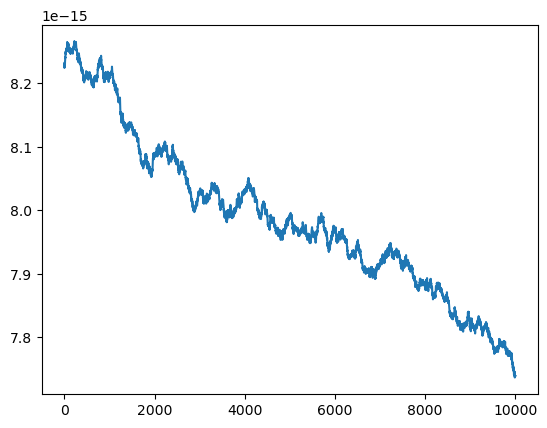

In [17]:
import h5py

with h5py.File('cimp_10k.hdf5', 'r') as f:
    print(f.keys())
    groupkey = list(f.keys())[0]
    data = list(f[groupkey])
    print(data)
    plotdata = list(f[groupkey]['emit'])
    print(emitz)

plt.plot(plotdata[2])

In [83]:
import h5py

filename = "testbunch.hdf5"

# with h5py.File(filename, 'r') as f:
#     print("Keys: %s" % f.keys())
#     a_group_key = list(f.keys())[0]
#     print(type(f[a_group_key]))
#     data = list(f[a_group_key])
#     data = list(f[a_group_key])
#     ds_obj = f[a_group_key]
#     print(ds_obj)
#     ds_arr = f[a_group_key]
#     print(ds_arr)
f = h5py.File(filename, 'r')
for key in f.keys():
    print(key) #Names of the root level object names in HDF5 file - can be groups or datasets.
    print(type(f[key])) # get the object type: usually group or dataset


#Get the HDF5 group; key needs to be a group name from above
group1 = f[key]

#Checkout what keys are inside that group.
for key in group.keys():
    print(key)

# This assumes group[some_key_inside_the_group] is a dataset, 
# and returns a np.array:
data = group[key][()]
#Do whatever you want with data
print(data)
# #After you are done
# f.close()

BunchData_1
<class 'h5py._hl.group.Group'>
cs_invariant
current
emit
mean
std
time
[0 0 0 0 0 0 0 0 0 0]


In [49]:
with open("emit_mai_27_cimp.txt", "w") as file:
    for el in emit_list:
        file.write(f'{el}\n')
with open("T_p_mai_27_cimp.txt", "w") as file:
    for el in T_array:
        file.write(f'{el}\n')
# test_data = np.loadtxt("emit_mai_24_bane.txt")
# test_data2 = np.loadtxt("T_p_mai.24_bane.txt")
# print(test_data)
# plt.plot(range(10_000), test_data)


In [ ]:
s = (-100, 100, 1000)
y = np.random.
np.random.rando

[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4
  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8
  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1  4.2
  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6
  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.
  7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4
  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8
  9.9 10. ]
[-1.6451 -0.2491  0.4677  0.9072  1.1987  1.4002  1.5431  1.6457  1.7195
  1.7724  1.8097  1.8351  1.8514  1.8606  1.8644  1.8639  1.8599  1.8532
  1.8445  1.834   1.8222  1.8094  1.7958  1.7815  1.7668  1.7518  1.7365
  1.7211  1.7056  1.6901  1.6746  1.6592  1.6438  1.6287  1.6136  1.5987
  1.584   1.5695  1.5551  1.541   1.5271  1.5134  1.4999  1.4866  1.4735
  1.4606  1.4479  1.4355  1.4232  1.4112  1.3993  1.3876  1.3761  1.3649
  1.3538  1.3429  1.3322  1.3216  1.3113  1.3011  1.29

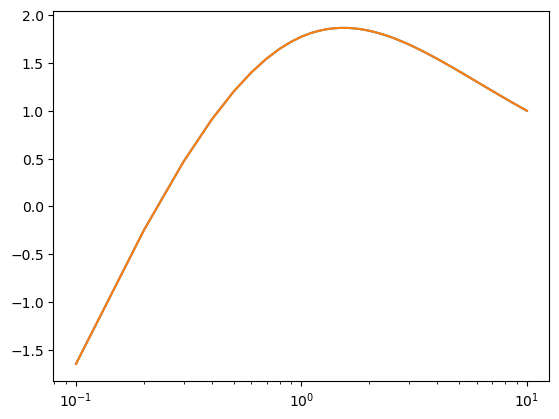

In [27]:
import scipy.special as le
import scipy.interpolate as inter


# legendre = lpmv(
x = np.linspace(0.1, 10, 100)
x1 = np.round(x, 1)
print(x1)

gdata = np.loadtxt("g_data.txt")
print(50*"=")
print(gdata)
yk = []


function = inter.interp1d(x1, gdata)

t = np.linspace(0.1, 10, 100)

def Puv(u, v, x):

    if x < 1:
        val = ((1 + x) / (1 - x))**(u/2) * hyp2f1(v+1, -v, 1-u, (.5 - (.5 * x)))
    else:
        val = ((x + 1) / (x - 1))**(u/2) * hyp2f1(v+1, -v, 1-u, (.5 - (.5 * x)))
    return val

def g_func(u):
    x_arg = (1+ u**2) / (2 * u)
    if u >= 1:
        g_val = np.sqrt(np.pi / u) * ((Puv(0, -.5, x_arg)) + ((3/2) * (Puv(-1, -.5, x_arg))))
    else:
        g_val = np.sqrt(np.pi / u) * ((Puv(0, -.5, x_arg)) - ((3/2) * (Puv(-1, -.5, x_arg))))
    return g_val

somelist = []
for i in x:
    el_list = g_func(i)
    somelist.append(el_list)


def g(u):
    vg = (2.691 * (1 - (0.2288964 / u))) / ((1 + 0.16 * u) * (1 + 1.35 * np.exp(-u/0.2)))
    return vg
ygg = []
for i in x:
    yg = g(i)
    ygg.append(yg)

yt = []
for i in t:
    el = function(i)
    yt.append(el)
    



plt.semilogx(x, somelist)



print(50*'~')
print(yk)
# plt.semilogx(x, yk, marker='.')
# plt.show()
plt.semilogx(t, yt)
# plt.semilogx(x, ygg)

initiating with U0=1, vc 1.8e6, ring, rf, rf2, sr(tau[3]*10000), 1*emit[:]


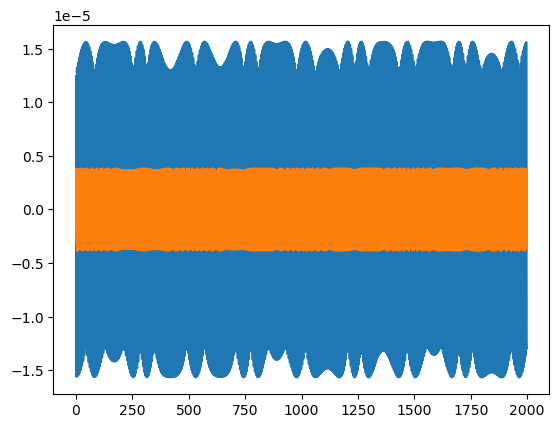

In [16]:
# %matplotlib qt
coords = np.array(coords)
# plt.plot(coords[5][0][1:10])
# plt.plot(coords[5][2][1:10])

# print(coords[1][0][0:10])
plt.plot(coords[:, 0, 1]) #0 is x
plt.plot(coords[:, 2, 1]) #2 is y
# # plt.plot(coords[:,0,1], coords[:,1,1])
print("initiating with U0=1, vc 1.8e6, ring, rf, rf2, sr(tau[3]*10000), 1*emit[:]")


In [12]:
histo = np.histogram(coords[0, 4, :], bins = 3190)
print(histo[0][1500])
# res, err = plt.hist(coords[0, 4, :], bins = 3190)
# print(res)


13


In [2]:
from scipy.constants import elementary_charge
ring2 = v2366(IDs="Open")
mbunch = Bunch(
        ring2, mp_number=10000, current=1.2e-3, track_alive=True
    )
np.random.seed(42)
mbunch.init_gaussian()
%matplotlib qt

s = np.linspace(0,ring2.L, 5000)

yx =ring2.optics.beta(s)[0]

plt.plot(s, yx, label=r"$\beta_x$")
yy = ring2.optics.beta(s)[1]
plt.plot(s, yy, label=r"$\beta_y$")
plt.xlabel("s(m)")
plt.ylabel(r" $\beta$ (m)")
plt.title("Beta function")
plt.xlim(140, 215)
plt.legend()
plt.show()


libGL error: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: iris
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


In [45]:
%matplotlib qt
z = np.linspace(0, ring2.L, 10000)
avg = []
for i in range(10000):
    z = np.linspace(0, ring2.L, i)
    y = np.average(ring2.optics.alpha(z)[0])
    avg.append(y)
plt.plot(avg)

/home/feddaoui/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)


In [40]:
print(m_e**2 * c**4/ coulomb)
p01 = np.sqrt((ring2.E0**2 - (m_e**2 * c**4))/c**2) * coulomb
print(p01)
dt = 1 / ring2.f0
print(f'{1.2e-3 * dt  / elementary_charge:.1e}')

4.1836024554645366e-08
1.4696786479865347e-18
8.8e+09


$E_0/c = [GeV]/[m/s]$

In [7]:
#test
def model_ring():
    h = 416 # Harmonic number of the accelerator.
    L = 353.97 # Ring circumference in [m].
    E0 = 2.75e9 # Nominal (total) energy of the ring in [eV].
    particle = Electron() # Particle considered.
    ac = 1.0695e-4
    U0 = 452.6e3# Energy loss per turn in [eV].
    tau = np.array([7.68e-3, 14.14e-3, 12.18e-3]) #zontal, vertical and longitudinal damping times in [s].
    tune = np.array([54.2, 18.3])
    emit = np.array([84.4e-12, 84.4e-13])
    sigma_0 = 9e-12
    sigma_delta = 9.07649e-4
    chro = np.array([1.6, 1.6])
    beta = np.array([3.288, 4.003])
    alpha = np.array([0, 0])
    dispersion = np.array([0, 0, 0, 0])
    optics = Optics(local_beta=beta, local_alpha=alpha, 
                      local_dispersion=dispersion)
    ring3 = Synchrotron(h=h, optics=optics, particle=particle, L=L, E0=E0, ac=ac,
                       U0=U0, tau=tau, emit=emit, tune=tune,
                       sigma_delta=sigma_delta, sigma_0=sigma_0, chro=chro)
    return ring3
# ring3 = model_ring()
# mybeam = Beam(ring)
# fill = np.zeros(ring.h)
# fill[:] = 1.2e-3
# mybeam.init_beam(fill, mp_per_bunch= 1e4)
# fig = mybeam.plot("bunch_emit", "y")


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

n_particles = 20000
mybunch = Bunch(ring, mp_number=n_particles, current=1e-3, track_alive=True)
np.random.seed(42)
mybunch.init_gaussian()
mybunch

ring2 = V3588(IDs="open")
ring = v2366(IDs="open") #default is open
emittance_x = ring.emit[0]*1
beta_x = ring.optics.local_beta[0]
print(ring.optics.local_beta)
print(ring.emit)
s = np.linspace(0, ring.L, 5555)
# plt.plot(x, ring.optics.gamma(x).T)
# plt.plot(x, ring.optics.alpha(x).T)
# plt.plot(x, ring.optics.beta(x).T)
# emit_x = (ring.optics.gamma(s)[0] * mybunch['x']**2) + (2 * ring.optics.alpha(s)[0] * mybunch['x'] * mybunch['xp']) + (ring.optics.beta(s)[0] * mybunch['xp']**2) 
# emit_y = (ring.optics.gamma(s)[1] * mybunch['y']**2) + (2 * ring.optics.alpha(s)[1] * mybunch['y'] * mybunch['yp']) + (ring.optics.beta(s)[1] * mybunch['yp']**2)


emit_x_t = np.std(mybunch['x'])**2 / ring.optics.beta(s)[0]
emit_y_t = np.std(mybunch['y'])**2 / ring.optics.beta(s)[1]

emit_x_avg = (ring.optics.gamma(s)[0] * np.std(mybunch['x'])**2) + (2 * ring.optics.alpha(s)[0] * np.std(mybunch['x']) * np.std(mybunch['xp'])) + (ring.optics.beta(s)[0] * np.std(mybunch['xp'])**2) 
emit_y_avg = (ring.optics.gamma(s)[1] * np.std(mybunch['y'])**2) + (2 * ring.optics.alpha(s)[1] * np.std(mybunch['y']) * np.std(mybunch['yp'])) + (ring.optics.beta(s)[1] * np.std(mybunch['yp'])**2)

with open("emitx_twiss", "w") as file:
    for el in emit_x:
        file.write(f'{el}\n')



NameError: name 'ring' is not defined

  0%|                                                 | 0/10000 [00:00<?, ?it/s]/home/feddaoui/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4432.70it/s]


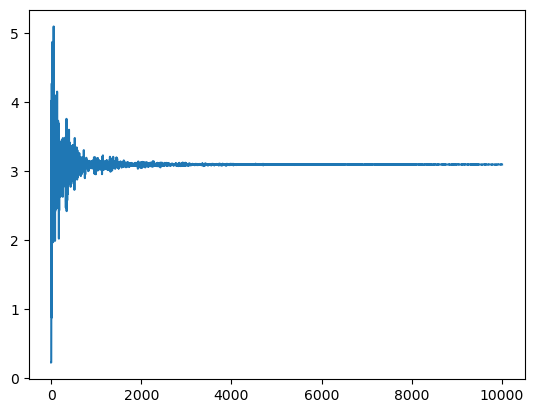

In [21]:
#check optics
data = []
for i in tqdm(range(10000)):
    z = np.linspace(0, ring.L, i)
    value = np.average(ring.optics.gamma(z))
    data.append(value)

plt.plot(data)

initiating with U0=1, vc 1.8e6, ring, rf, rf2, sr(tau[3]*10000), 1*emit[:]


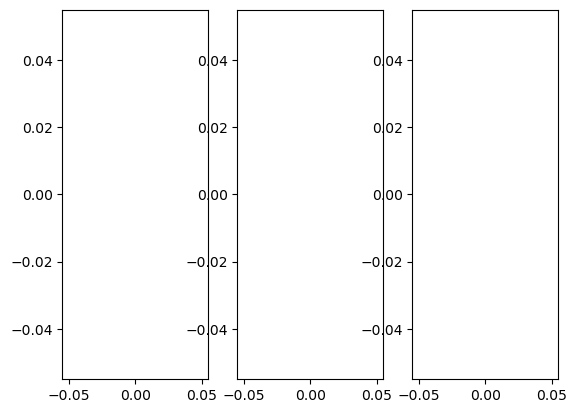

In [40]:
%matplotlib inline
i = 100
fig, axs = plt.subplots(1, 3)
for i in range(54, 60):
    axs[0].scatter(coords[:, 0, i], coords[:, 1, i], marker='.')
    axs[1].scatter(coords[:, 2, i], coords[:, 3, i], marker='.')
    axs[2].scatter(c*coords[:, 4, i], coords[:, 5, i], marker= '.')
# for ax in axs:
    # ax.set_xlim(-5e-5, 5e-5)
    # ax.set_ylim(-1e-5, 1e-5)
print("initiating with U0=1, vc 1.8e6, ring, rf, rf2, sr(tau[3]*10000), 1*emit[:]")

In [16]:
xmax = np.max(coords[:, 0, :], axis=1)
xmax = np.max(xmax)
n_turns = 4000
j = 0
k = 10
d_x = []
for i in range(3999):
    q_x = coords[j:k, 0, 0]
    q_x = np.absolute(q_x)
    min_qx = np.min(q_x)
    max_qx = np.max(q_x)
    delta_x = (max_qx - min_qx)
    d_x.append(delta_x)
    k += 1
    j += 1
# %matplotlib qt

# q_x = coords[30:40, 0, 0]
# q_x = np.absolute(q_x)
# min_qx = np.min(q_x)
# max_qx = np.max(q_x)
# delta_x = (max_qx - min_qx)
# print(q_x)
# print("min=", min_qx,"max=", max_qx)
# print(delta_x)
# plt.plot(d_x)############
plt.show()
a = 0
b = 1
    
betax = ring.optics.local_beta[0]
# emittancex = betax * coords[:, 0, 1]
# L_d_ex = []
# for i in range(4000):
#     d_emittancex1 = betax * coords[i, 0, 1]
#     a += 1
#     b += 1
#     d_emittancex2 = betax * coords[i+1, 0, 1]
#     d_ex = d_emittancex1 - d_emittancex2
#     L_d_ex.append(d_ex)

# print(emittancex)
# plt.plot(L_d_ex)
# plt.show()

In [17]:
print(1/ring.f0 * 4000)


0.004722871873052405


3999


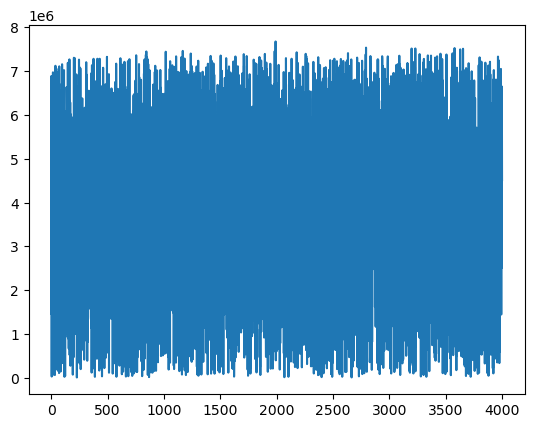

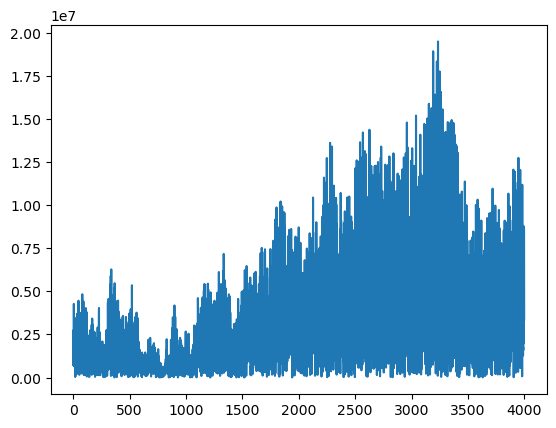

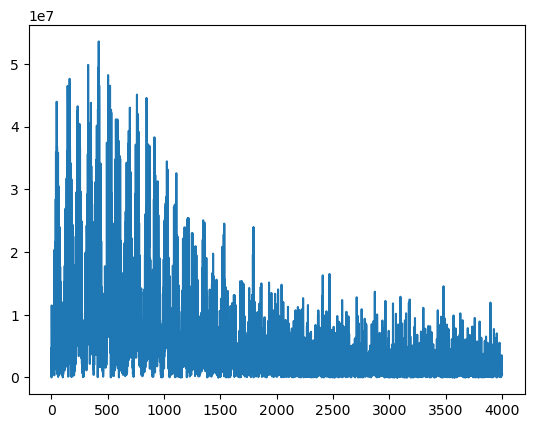

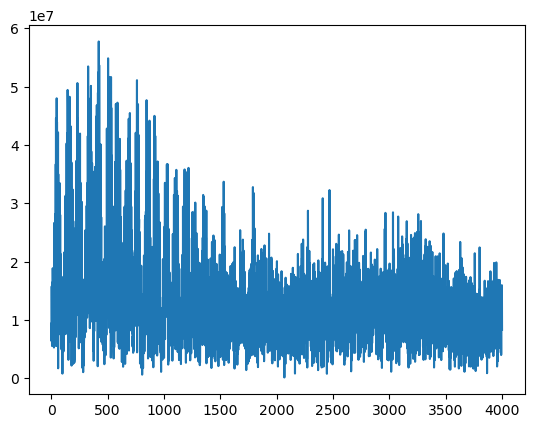

In [18]:
##makeshift IBS simulator##
#calculate the change of emittance over time (turns)
%matplotlib inline
betax = ring.optics.local_beta[0]
betay = ring.optics.local_beta[1]
Vx, Vy, Vz = [], [], []
# print(coords[0, 0, 1]**2 / betax)
# print(coords[1, 0, 1]**2 / betax)
for i in range(len(coords[:, 0])-1):
    d_emittancex1 = (np.std(coords[i, 0, :])**2 / betax) + (np.std(coords[i, 1, :]**2) / betax)
    d_emittancex2 = (np.std(coords[i+1, 0, :])**2 / betax) + (np.std(coords[i+1, 0, :]**2) / betax)    
    d = d_emittancex2 - d_emittancex1
    d = np.abs(d)
    Vx.append(d)
    if i == (len(coords[:, 0]) - 1):
        break
#delta should be a positive np.abs######################

for i in range(len(coords[:, 0])-1):
    d_emittancey1 = (coords[i, 2, 0]**2 / betay) + (coords[i, 3, 0]**2 / betay)
    d_emittancey2 = (coords[i+1, 2, 0]**2 / betay) + (coords[i+1, 3, 0]**2 / betay)    
    dy = d_emittancey2 - d_emittancey1
    dy = np.abs(dy)
    Vy.append(dy)
    if i == (len(coords[:, 0]) - 1):
        break
for i in range(len(coords[:, 0])-1):
    d_emittancez1 = np.std(coords[i, 5, :])
    d_emittancez2 = np.std(coords[i+1, 5, :])
    dz = d_emittancez2 - d_emittancez1
    dz = np.abs(dz)
    Vz.append(dz)
    if i == (len(coords[:, 0]) - 1):
        break



Vx, Vy # is the change of emittance over time and it can be positive or negative
dt = 1 / ring.f0

# L_emittancex = coords[:, 0, 1]**2 / betax
ref_emittance = emittance_x
Vx = np.array(Vx)
Vy = np.array(Vy)
Vz = np.array(Vz)
# fi = 1/(L - ref_emittance) #fi rate of change in ibs
# plt.plot(fi)
# emittance_x = ring.emit[0]*1
sigma_px = np.std(coords[:, 2, :], axis=1)
sigma_py = np.std(coords[:, 3, :], axis=1)
sigma_pz = np.std(coords[:, 5, :], axis=1)
sigma_z = np.std(coords[:, 4, :], axis=1)
L_emittancex = (np.std(coords[:, 0, :], axis=1)**2 / betax) + (np.std(coords[:, 1, :], axis=1)**2 * betax)
L_emittancey = (np.std(coords[:, 2, :], axis=1)**2 / betay) + (np.std(coords[:, 3, :], axis=1)**2 * betay)
L_z = np.std(coords[:, 5, :], axis=1)

###
Tibsx, Tibsy, Tibsz = [], [], []
Vx_dt = Vx / dt
Vy_dt = Vy / dt
Vz_dt = Vz / dt
n_particles = 10000
for i in range(len(Vx_dt)):
    ratex = np.sqrt(Vx_dt[i]) * n_particles * np.random.random() / np.sqrt(L_emittancex[i])
    ratey = np.sqrt(Vy_dt[i]) * n_particles * np.random.random() / np.sqrt(L_emittancey[i])
    ratez = Vz_dt[i] * n_particles * np.random.random() / L_z[i]
    Tibsx.append(ratex)
    Tibsy.append(ratey)
    Tibsz.append(ratez)

print(len(Tibsy))

Tibs = []
for i in range(len(Tibsx)):
    Ti = Tibsx[i] + Tibsy[i] + Tibsz[i]
    Tibs.append(Ti)



plt.plot(Tibsx) #square root of the emittance in x/y according to Piwinski
plt.show()
plt.plot(Tibsy)
plt.show()
plt.plot(Tibsz)
plt.show()
plt.plot(Tibs)
plt.show()

Tibs.append(Tibs[0])# 3999, -> 4000,


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 34385.18it/s]


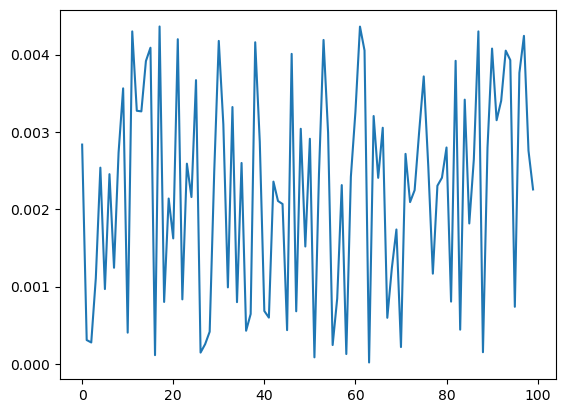

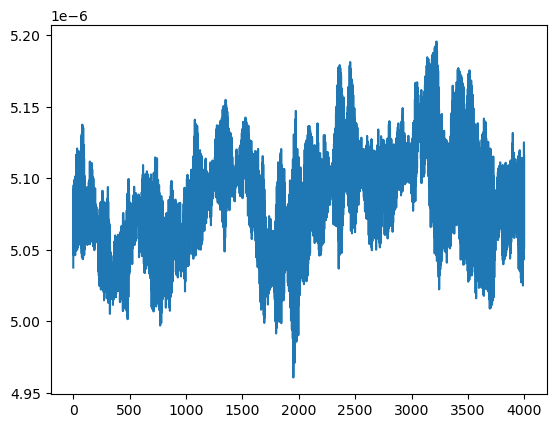

In [19]:
#calculating kick (delta pu)
sigma_px = np.std(coords[:, 2, :], axis=1)
sigma_py = np.std(coords[:, 3, :], axis=1)
sigma_pz = np.std(coords[:, 5, :], axis=1)
sigma_z = np.average(np.std(coords[:, 4, :], axis=1))
Spi = np.sqrt(np.pi)
Rho = n_particles / sigma_z
r1 = np.mean(np.std(coords[:, 0, :], axis=1))
r2 = np.mean(np.std(coords[:, 2, :], axis=1))

Tibs = np.array(Tibs)
sqrtx= 2 * Tibs  * sigma_z * dt * sigma_z * Spi * Rho
ATibs = np.average(Tibs)

#this method amount for the kick with a single time random generated number from 0 to 1
Lx, Ly, Lz = [], [], []
for i in tqdm(range(100)):
    dpx = sigma_px * np.sqrt(2 * ATibs * dt * sigma_z * Spi * Rho) * np.random.random()
    dpy = sigma_py * np.sqrt(2 * ATibs * dt * sigma_z * Spi * Rho) * np.random.random()
    dpz = sigma_pz * np.sqrt(2 * ATibs * dt * sigma_z * Spi * Rho) * np.random.random()
    Lx.append(dpx)
    Ly.append(dpy)
    Lz.append(dpz)

    
# dpx = sigma_px * np.sqrt(2 * Tibs * dt * sigma_z * Spi * Rho) * np.random.random()
# dpy = sigma_py * np.sqrt(2 * Tibs * dt * sigma_z * Spi * Rho) * np.random.random()
# dpz = sigma_pz * np.sqrt(2 * Tibs * dt * sigma_z * Spi * Rho) * np.random.random()
Lx = np.array(Lx)
plt.plot(np.average(Lx[:, :], axis=1))

# plt.plot(Lx)
plt.show()
plt.plot(np.std(coords[:, 1, :], axis=1))
plt.show()

In [20]:
print(type(sigma_px))

<class 'numpy.ndarray'>


13374968.01905802


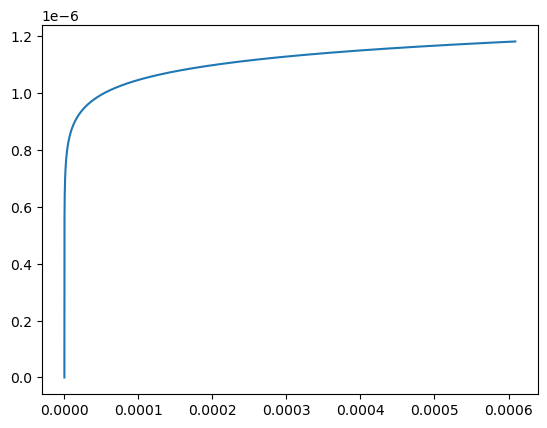

In [21]:
endpoint = 1
t = np.linspace(0, dt, 4000)
emit_t = ref_emittance * np.exp(ATibs * t)

print(ATibs)
plt.plot(emit_t, t)

In [100]:
# Tibs analytical#################
#-----------------------
# mybunch = ['x', 'xp', 'y', 'yp', 'tau', 'delta']
#----------------------

# dt = 1 / ring.f0
# Spi = np.sqrt(np.pi)
# r_0 = 2.82 * 1e-15
# betax = ring.optics.local_beta[0]
# betay = ring.optics.local_beta[1]
sigma_s = np.std(mybunch['tau'])
sigma_p = np.std(mybunch['delta'])
sigma_px = np.std(mybunch['xp'])
sigma_py = np.std(mybunch['yp'])
# Beta = ring.beta
# D_x = ring.optics.local_dispersion[0]
# D_y = ring.optics.local_dispersion[1]
# ring.optics.local_dispersion # x, dx, y, dy ?
# emit_x = (ring.optics.local_gamma[0] * np.std(mybunch['x']**2) +
#           ( 2 * ring.optics.local_alpha[0] * np.std(mybunch['x']) * np.std(mybunch['xp'])) +  
#           (ring.optics.local_beta[0] * np.std(mybunch['xp']**2))
# emit_y = (ring.optics.local_gamma[1] * np.std(mybunch['y']**2) + 
#           ( 2 * ring.optics.local_alpha[1] * np.std(mybunch['y']) * np.std(mybunch['yp'])) + 
#           (ring.optics.local_beta[1] * np.std(mybunch['yp']**2))

# emit_x1 = (ring.optics.local_gamma[0] * mybunch['x']**2) + (2 * ring.optics.local_alpha[0] * mybunch[''] * mybunch['']) + (ring.optics.local_beta[0] * mybunch['xp']**2) 



# A = r_0 * np.c * n_particles / 64 * np.pi**2 * Beta**3 * ring.gamma**4 * emit_x * emit_y * sigma_s * sigma_p

h = (1 / sigma_p**2) + (ring.optics.local_dispersion[0]**2 / betax * emit_x) + (ring.optics.local_dispersion[1]**2 / betay * emit_y)
 
sigma_h = np.sqrt(1 / h)
d = np.std(mybunch['x']) + np.std(mybunch['y']) / 2 # maximum impact parameter (beam size) we use here the RMS of the beam size(assumes beams gaussian(circular)!!!)
a = sigma_h / ring.gamma * np.sqrt(betax / emit_x)
b = sigma_h / ring.gamma * np.sqrt(betay / emit_y)
# q_bar = sigma_h * Beta * np.sqrt(2 * d / r_0) 
# model = 1#
######--------------------defining scattering functions
def scattering_abq(u, a, b):
    P = a**2 + (1 - a**2) * u**2
    Q = b**2 + (1 - b**2) * u**2
    f_abq = 8 * np.pi * (1 - 3 * u**2 / np.sqrt(P * Q) * (2 * np.log(q_bar * ((1/P) + (1/Q)) / 2) - 0.577777777))
    return f_abq

def scattering_1bq(u, a, b):
    P = (1/a**2) + (1 - (1/a**2)) * u**2
    Q = (b**2/a**2) + (1 - (b**2/a**2)) * u**2
    f_1aq = 8 * np.pi * (1 - 3 * u**2 / np.sqrt(P * Q) * (2 * np.log((q_bar/a) * ((1/P) + (1/Q)) / 2) - 0.577777777))
    return f_1aq

def scattering_1aq(u, a, b):
    P = (1/b**2) + (1 - (1/b**2)) * u**2
    Q = (a**2/b**2) + (1 - (a**2/b**2)) * u**2
    f_1bq = 8 * np.pi * (1 - 3 * u**2 / np.sqrt(P * Q) * (2 * np.log((q_bar/b) * ((1/P) + (1/Q)) / 2) - 0.577777777))
    return f_1bq

#####----------------------------
#computing intergrals                   
f_abq, error = quad.quad(scattering_abq, 0, 1, args=(a, b))
f_1aq, error = quad.quad(scattering_1aq, 0, 1, args=(a, b))
f_1bq, error = quad.quad(scattering_1bq, 0, 1, args=(a, b))
### a, b, q have varrying parameters can be arrays
T_p = A * (sigma_h**2/sigma_p**2) * f_abq  #(T_i = 1/T_i in the model)
T_x = A * f_1bq + (f_abq * D_x**2 * sigma_h**2 / betax * emit_x)
T_y = A * f_1aq + (f_abq * D_y**2 * sigma_h**2 / betay * emit_y)
#calculating momentum kick
slicing = np.std(mybunch['tau']) / r_0
dz = np.hist(mybunch['tau'], bins=slicing)[0]
# Rho = dz / r_0 #tbd
Rho = 1.0

Delta_pz = sigma_p * np.sqrt(2 * (1/T_p) * dt * sigma_s * Spi * Rho) * np.random.random()
Delta_px = sigma_px * np.sqrt(2 * (1/T_x) * dt * sigma_s * Spi * Rho) * np.random.random()
Delta_py = sigma_py * np.sqrt(2 * (1/T_y) * dt * sigma_s * Spi * Rho) * np.random.random()

mybunch['xp'] += Delta_px
mybunch['yp'] += Delta_py
mybunch['delta'] += Delta_pz
        # mybunch['xp'], mybunch['yp'], mybunch['delta']

                 

#######################

NameError: name 'sigma_p' is not defined

In [16]:
sizez = np.std(coords[1, 4, :], axis=0)
slicing = sizez / (2.82 * 1e-15)
print(slicing)

3190.1304147975648


In [27]:
c

299792458.0

In [89]:
import scipy.integrate

# Define the function
def func(x, a, b):
    return a*x + b

# Define the parameters a and b
a = 2
b = 3

# Define the limits of integration
lower_limit = 0
upper_limit = 1

# Compute the definite integral of the function over the interval [0, 1]
result, error = scipy.integrate.quad(func, lower_limit, upper_limit, args=(a, b))

print("Result:", result)
print("Estimated error:", error)


Result: 4.0
Estimated error: 4.440892098500626e-14


emittance x 8.4e-11, emittance y 8.4e-12


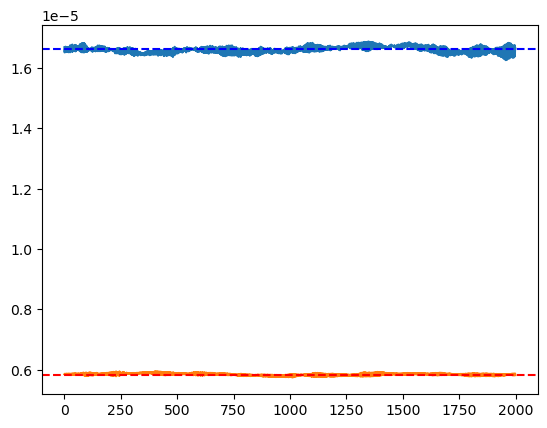

twiss B 1.66271597169039e-05


In [16]:
# %matplotlib inline
std_x = np.std(coords[:, 0, :], axis=1)
std_y = np.std(coords[:, 2, :], axis=1)
std_z = np.std(coords[:, 4, :], axis=1)
plt.plot(std_x)
plt.axhline(np.sqrt(emittance_x*beta_x), color='b', ls='dashed') #x0 trajectory
plt.plot(std_y)

emittance_y = ring.emit[1]*1
beta_y = ring.optics.local_beta[1]
plt.axhline(np.sqrt(emittance_y*beta_y), color='r', ls='dashed')
print(f'emittance x {emittance_x:.1e}, emittance y {emittance_y:.1e}')
plt.show()
# plt.plot(std_z)
# plt.show()
# %matplotlib qt
# figo, axi = plt.subplots(1,3)
# axi[0].plot(std_x)

# axi[1].plot(std_y)
# axi[2].plot(std_z)
print("twiss B", np.sqrt(emittance_x*beta_x))

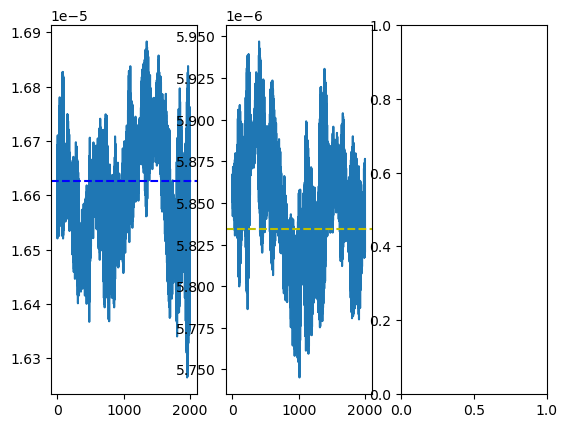

In [17]:
%matplotlib inline
fig, axies = plt.subplots(1, 3)
axies[0].plot(std_x)
axies[0].axhline(np.sqrt(emittance_x*beta_x), color='b', ls='dashed')
axies[1].plot(std_y)
axies[1].axhline(np.sqrt(emittance_y*beta_y), color='y', ls='dashed')
        

(4000, 6, 10000)

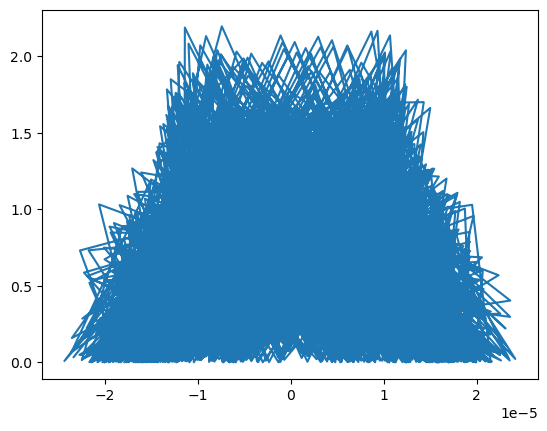

In [12]:
x1 = coords[:, 0, 0]
num_turns= coords[:, 0, 1]
beta_x1 = x1**2/(ring.emit[0]*10)
plt.plot(num_turns, beta_x1)
coords.shape
#4000 turns, 6 axies, 10000 particles

In [ ]:
print(np.mean(beta_x))


In [ ]:
# %matplotlib qt
# coords[0, 0, :].shape
# coords[0, 0, :]
# fig, axx= plt.subplots(1,4)
# axx[0].plot(coords[:,0,0], beta_x1)
# axx[1].plot(coords[:,1,0], beta_x1)
# axx[2].plot(coords[:,2,0], beta_x1)
# axx[3].plot(coords[:,4,0], beta_x1)
# plt.xlim(0,1.0e-12)